In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from itertools import chain
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk import ngrams
import warnings# to avoid the warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("C:/Users/ranja/OneDrive/Desktop/DATASET/mbti_1.csv")
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [3]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
data.describe()

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq    1832                                                  1

In [6]:
_classes = data.type.unique()
print(_classes)

['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


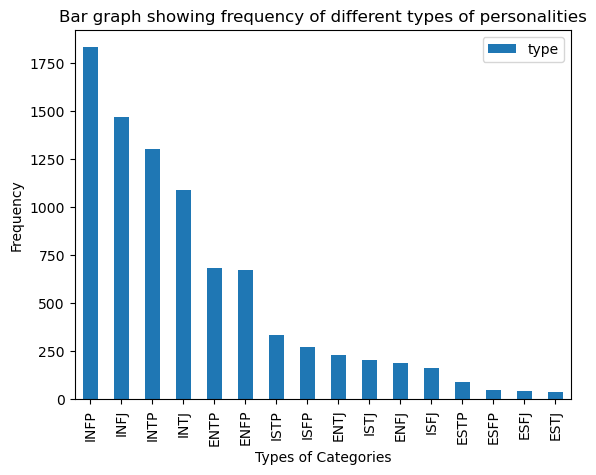

In [7]:
pd.DataFrame(data.type.value_counts()).plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Types of Categories')
plt.title('Bar graph showing frequency of different types of personalities')
plt.show()

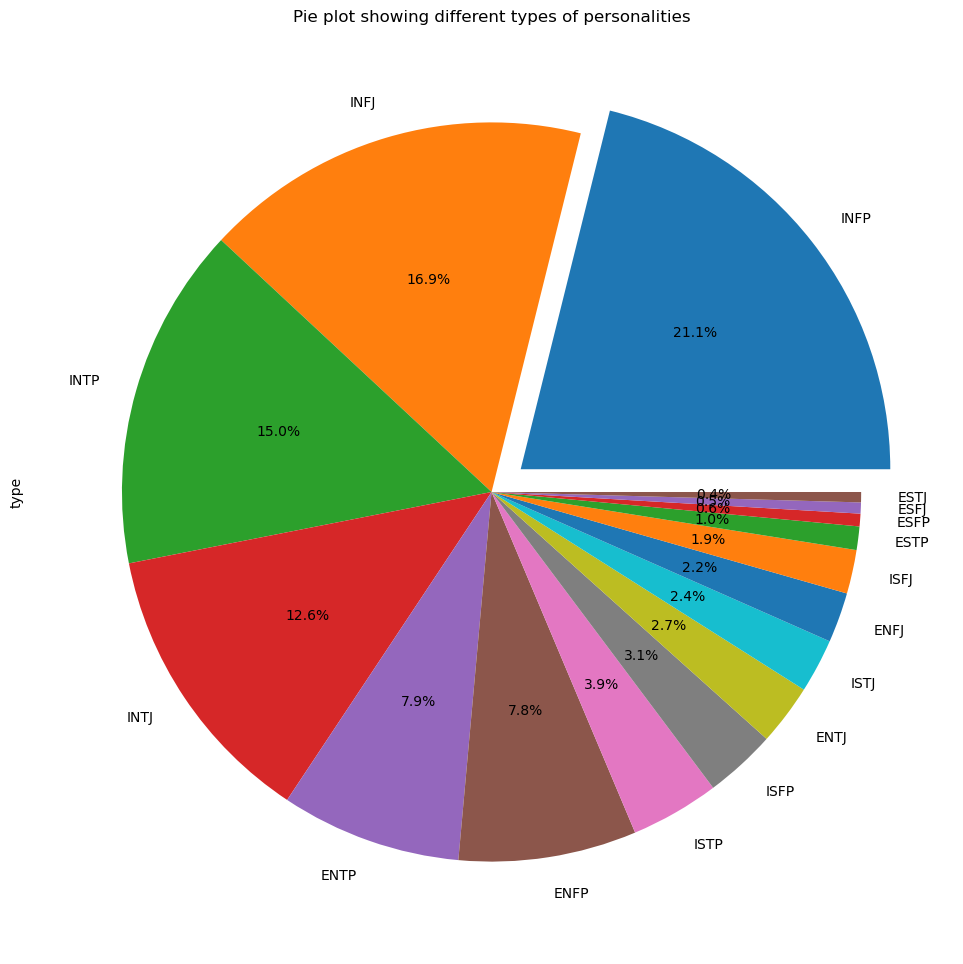

In [8]:
data.type.value_counts().plot(kind='pie',figsize=(12,12), autopct='%1.1f%%', explode=[0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('Pie plot showing different types of personalities')
plt.show()

Text(0.5, 1.0, 'Distribution of lengths of the post')

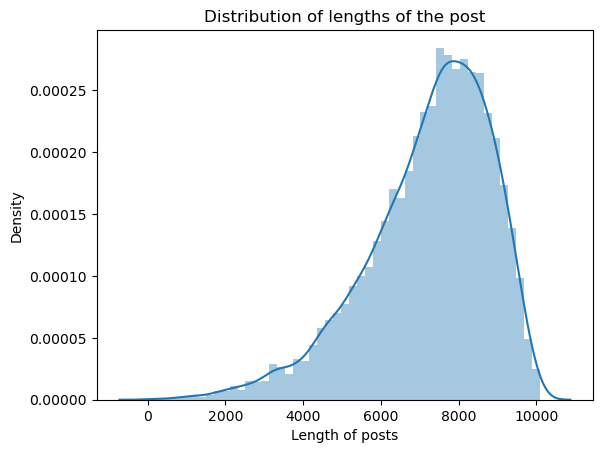

In [9]:
sns.distplot(data["posts"].apply(len))
plt.xlabel("Length of posts")
plt.ylabel("Density")
plt.title("Distribution of lengths of the post")

In [10]:
data["posts"] = data["posts"].str.lower()


for i in range(len(data)):
  post_temp=data._get_value(i, 'posts')
  pattern = re.compile(r'https?://[a-zA-Z0-9./-]*/[a-zA-Z0-9?=_.]*[_0-9.a-zA-Z/-]*')    #to match url links present in the post
  post_temp= re.sub(pattern, ' ', post_temp)                                            #to replace that url link with space
  data._set_value(i, 'posts',post_temp)
     

for i in range(len(data)):
  post_temp=data._get_value(i, 'posts')
  pattern = re.compile(r'[0-9]')                                    #to match numbers from 0 to 9
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile('\W+')                                       #to match alphanumeric characters
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile(r'[_+]')
  post_temp= re.sub(pattern, ' ', post_temp)
  data._set_value(i, 'posts',post_temp)
     

for i in range(len(data)):
  post_temp=data._get_value(i, 'posts')
  pattern = re.compile('\s+')                                     #to match multiple whitespaces
  post_temp= re.sub(pattern, ' ', post_temp)                      #to replace them with single whitespace
  data._set_value(i, 'posts', post_temp)

In [11]:
remove_words = stopwords.words("english")
for i in range(data.shape[0]):
  post_temp=data._get_value(i, 'posts')
  post_temp=" ".join([w for w in post_temp.split(' ') if w not in remove_words])    #to remove stopwords
  data._set_value(i, 'posts', post_temp)

In [12]:
def show_class_distribution(data, x="type", figsize=(16,4), title="Distribution of Personality Types", xticks_size=10, palette="husl"):
    plt.figure(figsize=figsize)
    sns.countplot(x=x, data=data, palette=palette)
    plt.xlabel("Personality Types", size=15)
    plt.ylabel("Counts", size=15)
    plt.xticks(size=xticks_size)
    plt.title(title, size=20)
    plt.show()

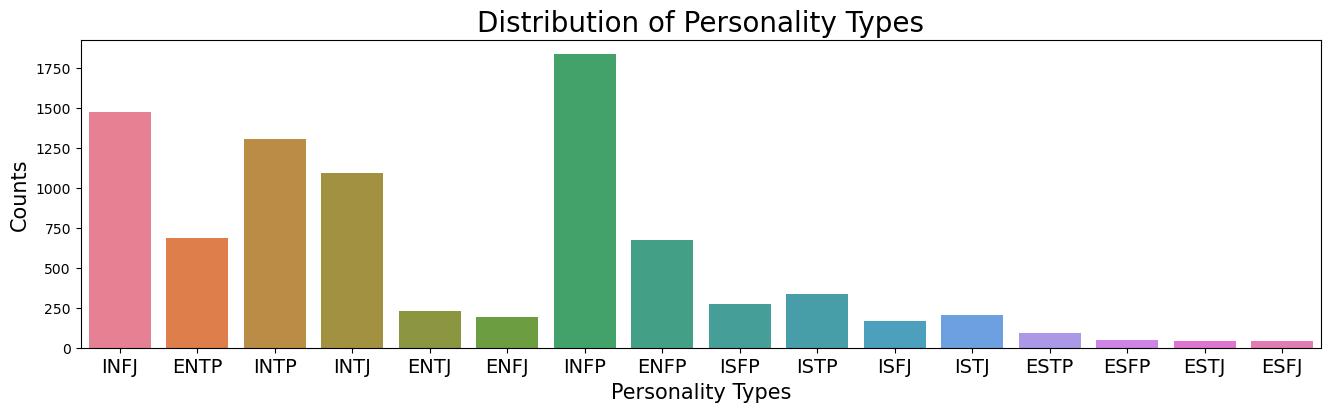

In [13]:
show_class_distribution(data, xticks_size=14)

In [14]:
def divide_types(df):
    df["E-I"] = ""
    df["N-S"] = ""
    df["F-T"] = ""
    df["J-P"] = ""
    for index, row in df.iterrows():
        row["E-I"] = "E" if row.type[0] == "E" else "I"
        row["N-S"] = "N" if row.type[1] == "N" else "S"
        row["F-T"] = "F" if row.type[2] == "F" else "T"
        row["J-P"] = "J" if row.type[3] == "J" else "P"
    return df

data = divide_types(data)

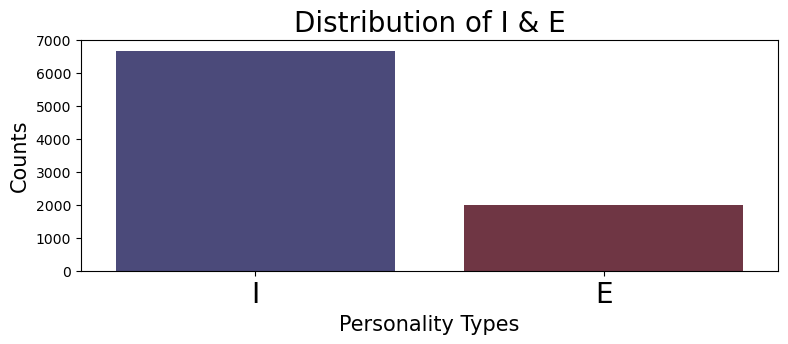

In [15]:
show_class_distribution(data, x="E-I", title="Distribution of I & E", figsize=(9,3), xticks_size=20, palette="icefire")

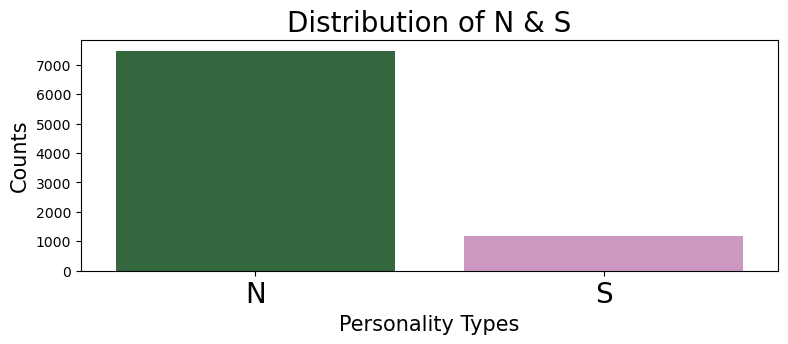

In [16]:
show_class_distribution(data, x="N-S", title="Distribution of N & S", figsize=(9,3), xticks_size=20, palette="cubehelix")

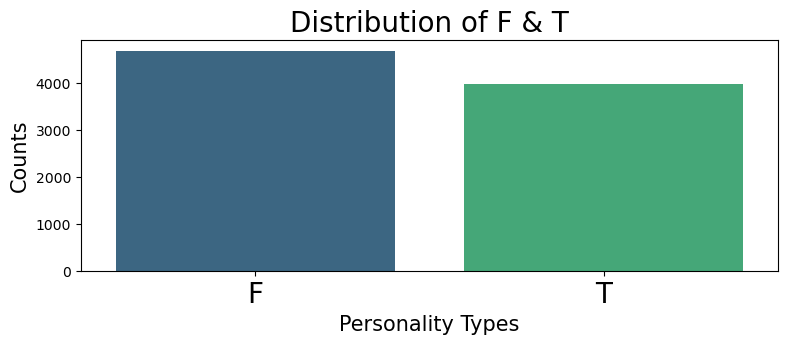

In [17]:
show_class_distribution(data, x="F-T", title="Distribution of F & T", figsize=(9,3), xticks_size=20, palette="viridis")

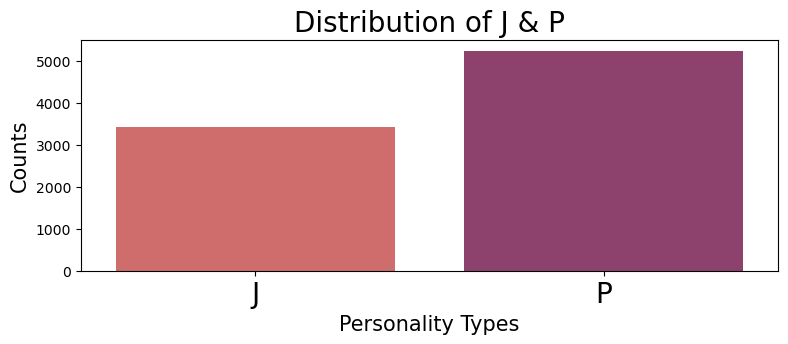

In [18]:
show_class_distribution(data, x="J-P", title="Distribution of J & P", figsize=(9,3), xticks_size=20, palette="flare")

In [19]:
data.loc[7, "posts"]

' tend build collection things desktop use frequently move folder called everything get sorted type sub type ike collect odd objects even work lot people would call junk like collect old unused software ill take hands bunch old adobe think quite normal tend see friends real life every couple months said earlier people dont get good ones edit mostly mean tolerate go sleep dreaming another form awake many layers thoughts sleep keep night edit sometimes im scared thanks wish free follow interests desired feel though wishes meant impossible things seeing mean visual interpreting seeing mentally understanding concept hello feel though incapable creating anything wish could cant stand interviewer christ laugh intj hmmm would interesting see intj show doubt would interesting general public though know think fi fe sounds like one think sounds like require input others know question intjs lean towards alternative rock types music answer well went pages sorted songs genre style sometimes look pe

In [20]:
def fix_contractions(df, column_name = "posts", new_column="cleaned_post"):
    df[new_column] = df[column_name].apply(lambda x: contractions.fix(x))
    return df

data = fix_contractions(data)
def clean_data(df, column_name = "cleaned_post"):
    df[column_name] = df[column_name].apply(lambda x: x.lower())
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'@([a-zA-Z0-9_]{1,50})', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'#([a-zA-Z0-9_]{1,50})', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'http[s]?://\S+', '', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^A-Za-z]+', ' ', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(r' +', ' ', x))
    df[column_name] = df[column_name].apply(lambda x: " ".join([word for word in x.split() if not len(word) <3]))
    return df

data = clean_data(data)

In [21]:
data.loc[7,"cleaned_post"]

'tend build collection things desktop use frequently move folder called everything get sorted type sub type ike collect odd objects even work lot people would call junk like collect old unused software ill take hands bunch old adobe think quite normal tend see friends real life every couple months said earlier people not get good ones edit mostly mean tolerate sleep dreaming another form awake many layers thoughts sleep keep night edit sometimes scared thanks wish free follow interests desired feel though wishes meant impossible things seeing mean visual interpreting seeing mentally understanding concept hello feel though incapable creating anything wish could cannot stand interviewer christ laugh intj hmmm would interesting see intj show doubt would interesting general public though know think sounds like one think sounds like require input others know question intjs lean towards alternative rock types music answer well went pages sorted songs genre style sometimes look people see wel

In [22]:
data["words_count"] = data["cleaned_post"].apply(lambda x: len(x.split()))
data.head(5)

type                                              posts E-I N-S F-T J-P  \
0  INFJ   enfp intj moments sportscenter top ten plays ...   I   N   F   J   
1  ENTP   finding lack posts alarming sex boring positi...   E   N   T   P   
2  INTP   good one course say know blessing curse absol...   I   N   T   P   
3  INTJ   dear intp enjoyed conversation day esoteric g...   I   N   T   J   
4  ENTJ   fired another silly misconception approaching...   E   N   T   J   

                                        cleaned_post  words_count  
0  enfp intj moments sportscenter top ten plays p...          301  
1  finding lack posts alarming sex boring positio...          542  
2  good one course say know blessing curse absolu...          417  
3  dear intp enjoyed conversation day esoteric ga...          506  
4  fired another silly misconception approaching ...          464

In [23]:
def plot_counts(df, column, xlabel):
    fig = plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    df[column].plot.hist(bins=25)

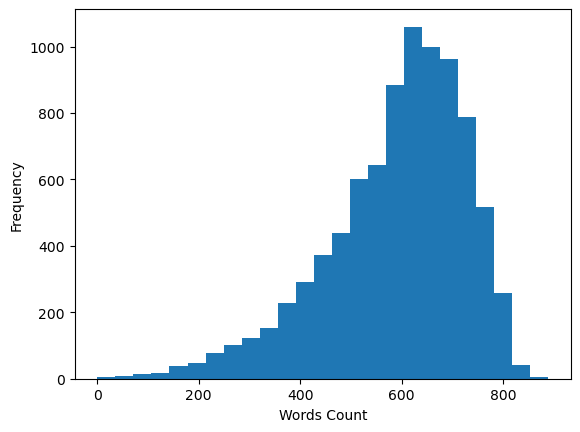

In [24]:
plot_counts(data, column="words_count", xlabel="Words Count")

In [25]:
data["char_count"] = data["cleaned_post"].apply(lambda x: len(x))
data.head(5)

type                                              posts E-I N-S F-T J-P  \
0  INFJ   enfp intj moments sportscenter top ten plays ...   I   N   F   J   
1  ENTP   finding lack posts alarming sex boring positi...   E   N   T   P   
2  INTP   good one course say know blessing curse absol...   I   N   T   P   
3  INTJ   dear intp enjoyed conversation day esoteric g...   I   N   T   J   
4  ENTJ   fired another silly misconception approaching...   E   N   T   J   

                                        cleaned_post  words_count  char_count  
0  enfp intj moments sportscenter top ten plays p...          301        2051  
1  finding lack posts alarming sex boring positio...          542        3591  
2  good one course say know blessing curse absolu...          417        2884  
3  dear intp enjoyed conversation day esoteric ga...          506        3475  
4  fired another silly misconception approaching ...          464        3259

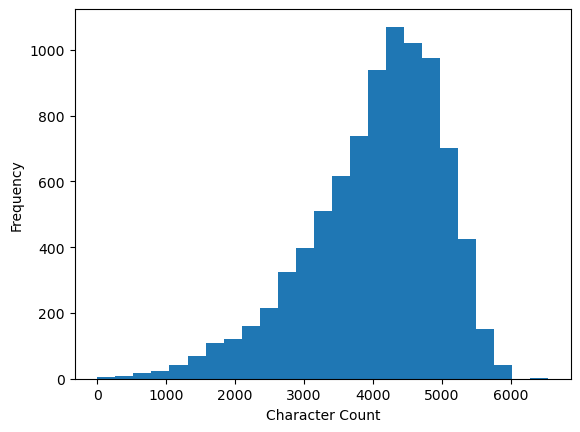

In [26]:
plot_counts(data, column="char_count", xlabel="Character Count")

In [27]:
def get_most_frequent(data, stop_words, column="cleaned_post", top=25):
    df = data[column].apply(lambda x: " ".join([word for word in x.split() if not word in stop_words]))
    counter = Counter(" ".join(df).split())
    return counter.most_common(top)

In [28]:
nltk.download('stopwords')
stopword_list = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ranja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
most_frequents = get_most_frequent(data, stopword_list)
most_frequents[:10]

[('like', 69690),
 ('think', 49842),
 ('people', 48177),
 ('know', 38173),
 ('one', 37226),
 ('really', 35355),
 ('would', 35349),
 ('get', 30814),
 ('time', 27617),
 ('feel', 23339)]

In [30]:
def show_most_frequents(most_frequent_words, top=20):
    most_frequent_df = pd.DataFrame(most_frequent_words)    
    plt.figure(figsize=(16,4))
    my_cmap = plt.get_cmap("viridis")
    plt.bar(x=most_frequent_df.iloc[:top, 0], height=most_frequent_df.iloc[:top, 1], color="slateblue")
    plt.xlabel("Words", size=17)
    plt.ylabel("Counts", size=17)
    plt.title("Most Frequent Words", size = 20)
    plt.show()

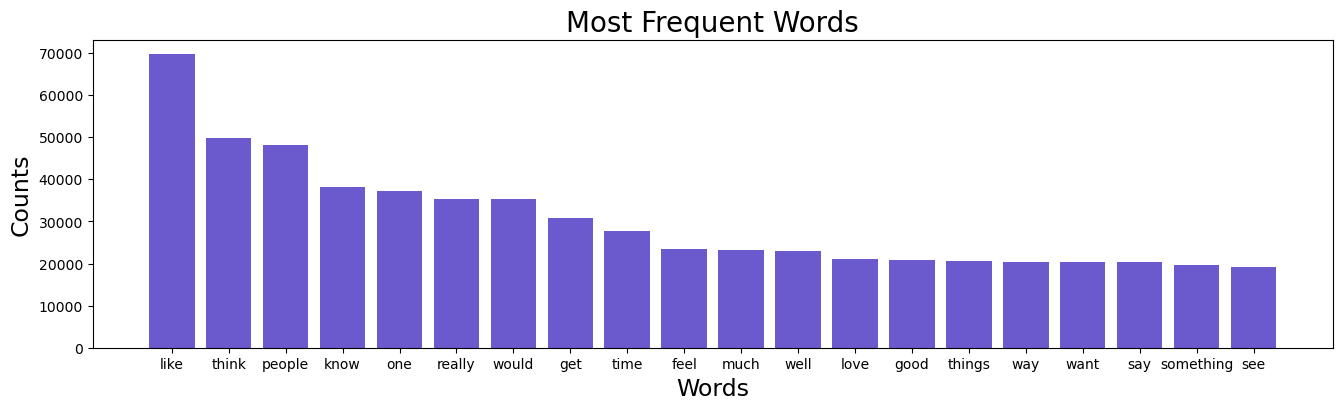

In [31]:
show_most_frequents(most_frequents)

In [32]:
def show_wordcloud(data, stopword_list, column="cleaned_post"):
    fig = plt.figure(figsize=(15,5))
    wordcloud = WordCloud(background_color="black", min_font_size=5, stopwords=stopword_list).generate(data[column].to_string())
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()

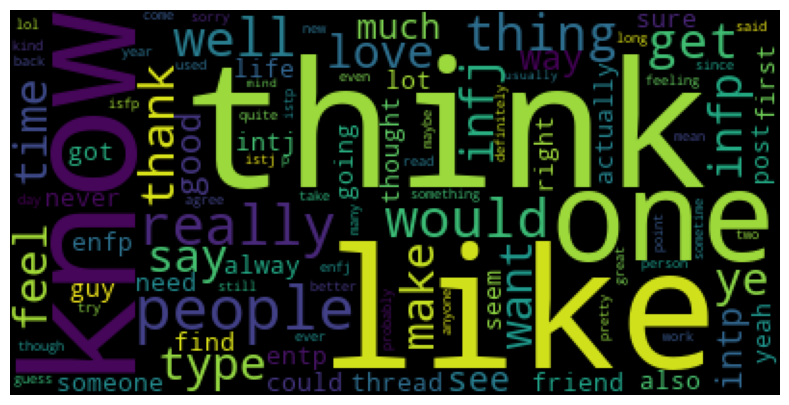

In [33]:
show_wordcloud(data, stopword_list)

In [34]:
def show_sub_wordclouds(data, type_column, column, size, fig_size=(20,15)):
    classes = data[type_column].unique()
    fig, ax = plt.subplots(len(classes), figsize=fig_size)
    j = 0
    for _class in classes:
        temp = data[data[type_column] == _class]
        wordcloud = WordCloud(background_color="black").generate(temp[column].to_string())
        plt.subplot(*size, j+1)
        plt.title(_class, size=25)
        plt.imshow(wordcloud)
        plt.axis("off")
        j+=1

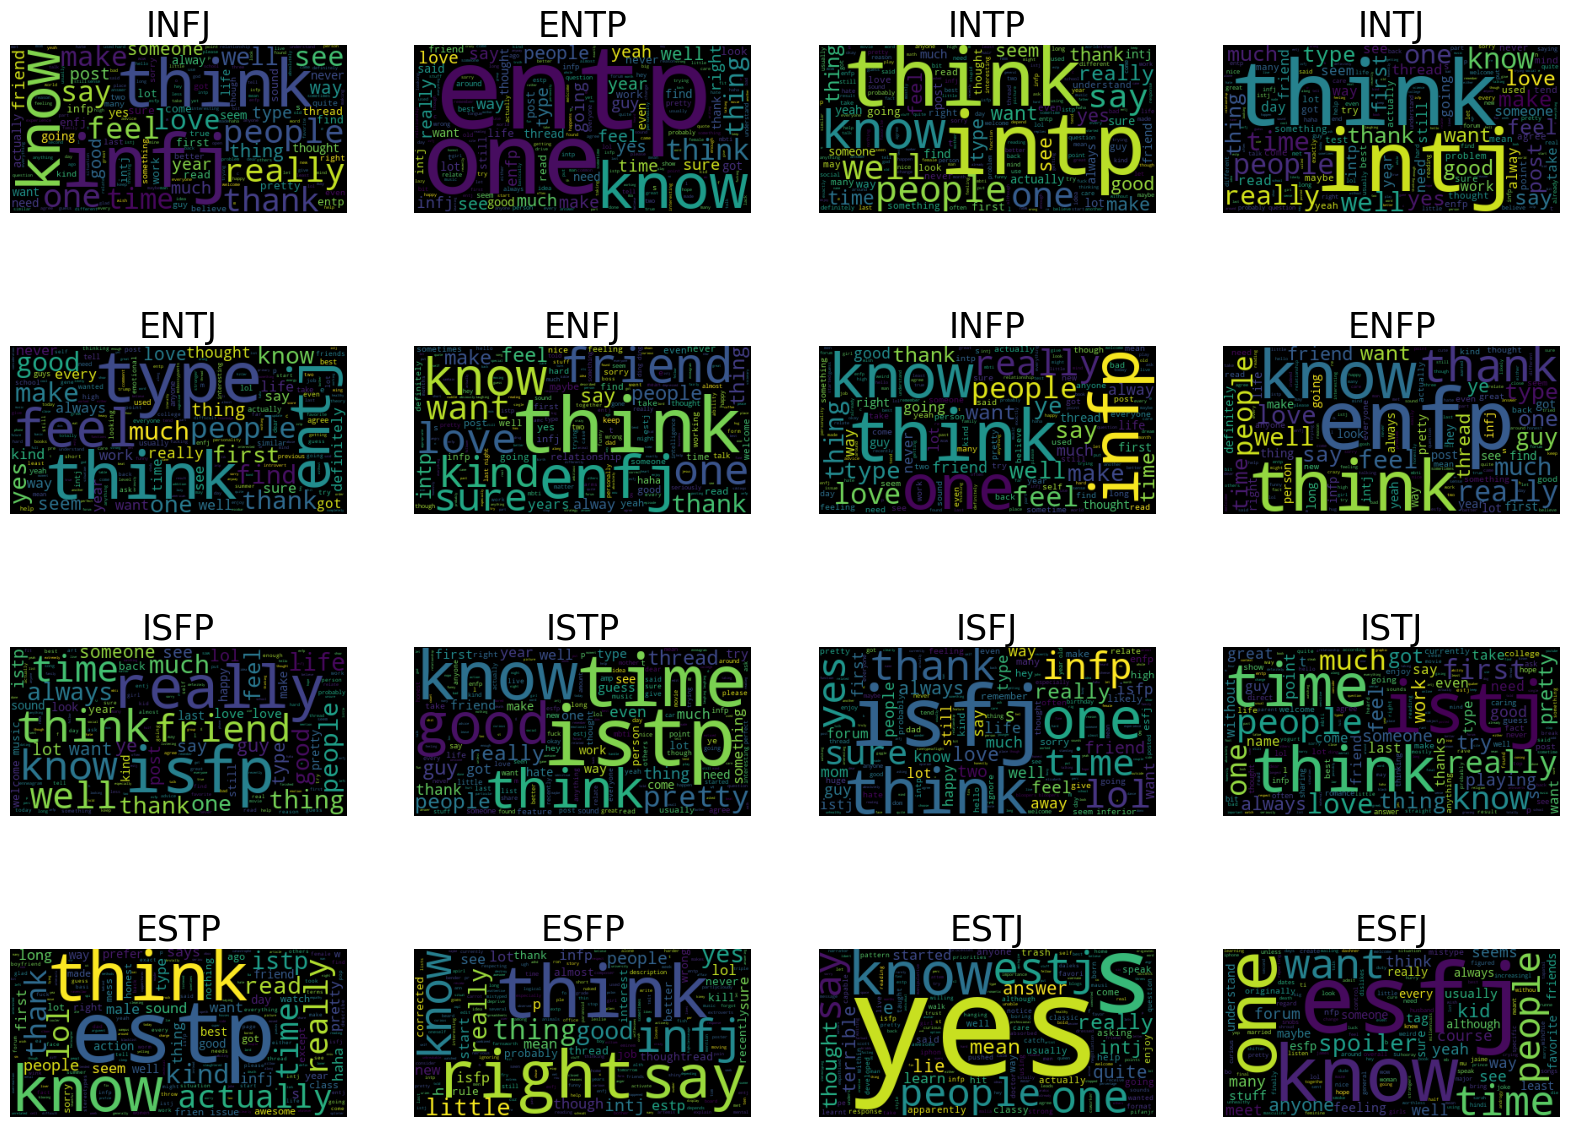

In [35]:
show_sub_wordclouds(data, type_column="type" , column="cleaned_post", size=(4,4))

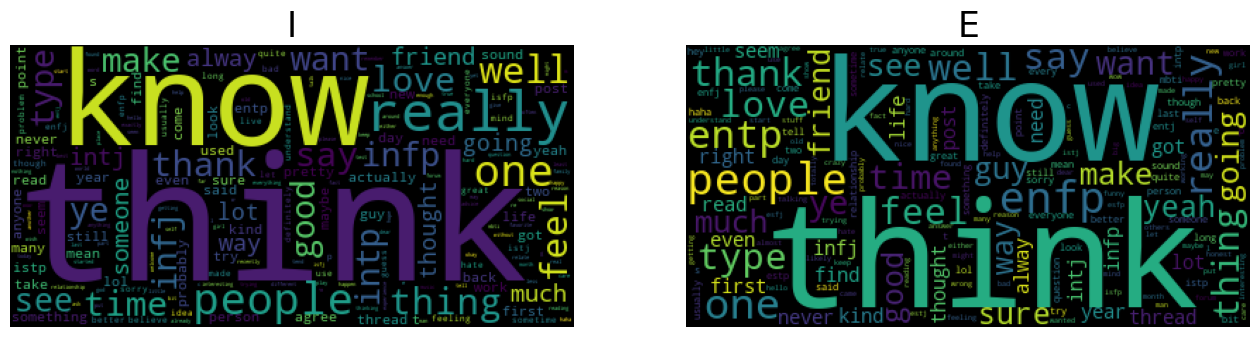

In [36]:
show_sub_wordclouds(data, type_column="E-I" , column="cleaned_post", size=(1,2), fig_size=(16,8))

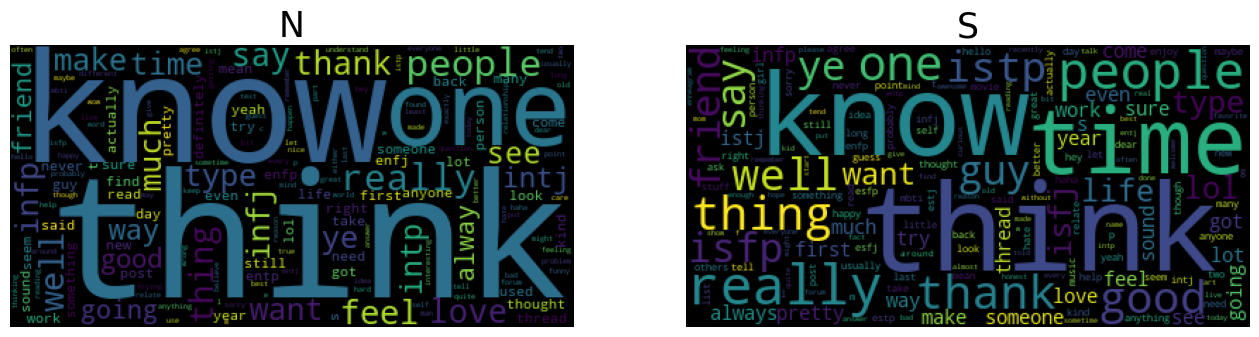

In [37]:
show_sub_wordclouds(data, type_column="N-S" , column="cleaned_post", size=(1,2), fig_size=(16,8))

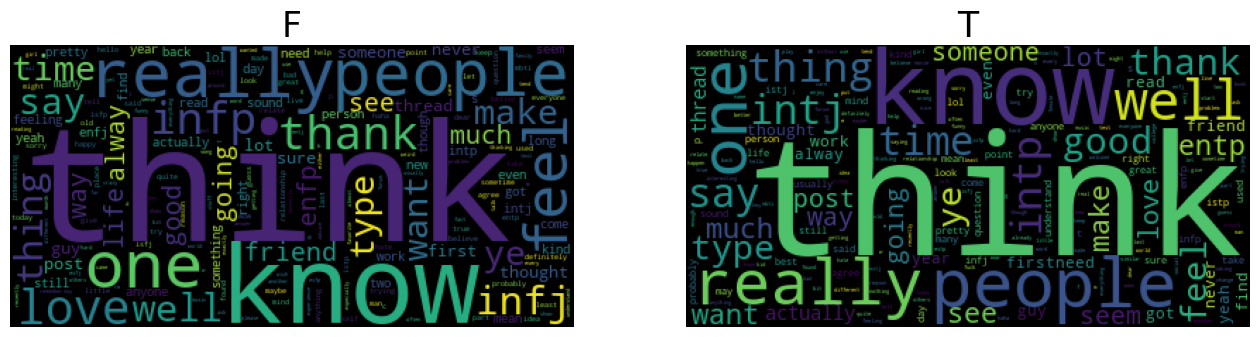

In [38]:
show_sub_wordclouds(data, type_column="F-T" , column="cleaned_post", size=(1,2), fig_size=(16,8))

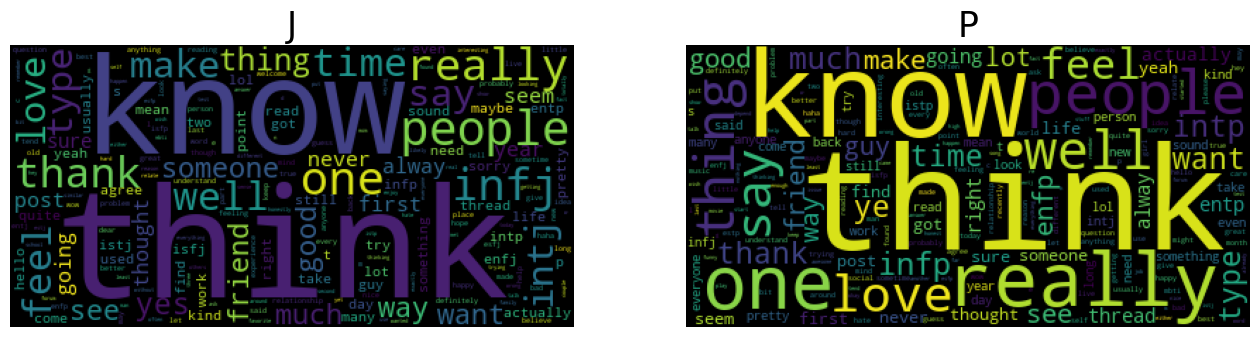

In [39]:
show_sub_wordclouds(data, type_column="J-P" , column="cleaned_post", size=(1,2), fig_size=(16,8))

In [40]:
def get_ngrams(data, n_gram, new_column, column="cleaned_post"):
    data["tokenized"]  = data[column].apply(lambda x: x.split())
    data["sw_removal"] = data["tokenized"].apply(lambda x: [y for y in x if not y in stopword_list])
    data[new_column]   = data["sw_removal"].apply(lambda x: list(ngrams(x, n_gram)))
    data.drop(columns  = ["tokenized", "sw_removal"], inplace=True)
    return data

In [41]:
data = get_ngrams(data, n_gram=2, new_column="bigrams")
data.head()

type                                              posts E-I N-S F-T J-P  \
0  INFJ   enfp intj moments sportscenter top ten plays ...   I   N   F   J   
1  ENTP   finding lack posts alarming sex boring positi...   E   N   T   P   
2  INTP   good one course say know blessing curse absol...   I   N   T   P   
3  INTJ   dear intp enjoyed conversation day esoteric g...   I   N   T   J   
4  ENTJ   fired another silly misconception approaching...   E   N   T   J   

                                        cleaned_post  words_count  char_count  \
0  enfp intj moments sportscenter top ten plays p...          301        2051   
1  finding lack posts alarming sex boring positio...          542        3591   
2  good one course say know blessing curse absolu...          417        2884   
3  dear intp enjoyed conversation day esoteric ga...          506        3475   
4  fired another silly misconception approaching ...          464        3259   

                                             bigrams  
0  [(enfp, intj), (intj, moments), (moments, spor...  
1  [(finding, lack), (lack, posts), (posts, alarm...  
2  [(good, one), (one, course), (course, say), (s...  
3  [(dear, intp), (intp, enjoyed), (enjoyed, conv...  
4  [(fired, another), (another, silly), (silly, m...

In [42]:
data = get_ngrams(data, n_gram=3, new_column="trigrams")
data.head()

type                                              posts E-I N-S F-T J-P  \
0  INFJ   enfp intj moments sportscenter top ten plays ...   I   N   F   J   
1  ENTP   finding lack posts alarming sex boring positi...   E   N   T   P   
2  INTP   good one course say know blessing curse absol...   I   N   T   P   
3  INTJ   dear intp enjoyed conversation day esoteric g...   I   N   T   J   
4  ENTJ   fired another silly misconception approaching...   E   N   T   J   

                                        cleaned_post  words_count  char_count  \
0  enfp intj moments sportscenter top ten plays p...          301        2051   
1  finding lack posts alarming sex boring positio...          542        3591   
2  good one course say know blessing curse absolu...          417        2884   
3  dear intp enjoyed conversation day esoteric ga...          506        3475   
4  fired another silly misconception approaching ...          464        3259   

                                             bigrams  \
0  [(enfp, intj), (intj, moments), (moments, spor...   
1  [(finding, lack), (lack, posts), (posts, alarm...   
2  [(good, one), (one, course), (course, say), (s...   
3  [(dear, intp), (intp, enjoyed), (enjoyed, conv...   
4  [(fired, another), (another, silly), (silly, m...   

                                            trigrams  
0  [(enfp, intj, moments), (intj, moments, sports...  
1  [(finding, lack, posts), (lack, posts, alarmin...  
2  [(good, one, course), (one, course, say), (cou...  
3  [(dear, intp, enjoyed), (intp, enjoyed, conver...  
4  [(fired, another, silly), (another, silly, mis...

In [43]:
def most_common_ngram(data, column, top=20):
    temp = []
    for index, row in data.iterrows():
        temp += row[column]
    most_common = Counter(temp).most_common(top)
    return most_common

def plot_n_grams(ngrams, title, top=20):
    ngram_df = pd.DataFrame(ngrams)
    ngram_df.iloc[:, 0] = ngram_df.iloc[:,0].astype(str)
    plt.figure(figsize=(7,7))
    plt.barh(y=ngram_df.iloc[:top, 0], width=ngram_df.iloc[:top, 1])
    plt.xlabel("Counts", size=17)
    plt.ylabel("Pairs", size=17)
    plt.title(title, size = 20)
    plt.show() 

In [44]:
bigrams_most_common = most_common_ngram(data, "bigrams")
bigrams_most_common

[(('feel', 'like'), 5647),
 (('sounds', 'like'), 2615),
 (('pretty', 'much'), 2415),
 (('high', 'school'), 2220),
 (('would', 'say'), 2012),
 (('even', 'though'), 1925),
 (('seems', 'like'), 1905),
 (('would', 'like'), 1839),
 (('best', 'friend'), 1693),
 (('really', 'like'), 1583),
 (('get', 'along'), 1551),
 (('years', 'ago'), 1462),
 (('long', 'time'), 1459),
 (('using', 'tapatalk'), 1376),
 (('personality', 'type'), 1297),
 (('something', 'like'), 1283),
 (('someone', 'else'), 1272),
 (('many', 'people'), 1271),
 (('people', 'think'), 1232),
 (('things', 'like'), 1189)]

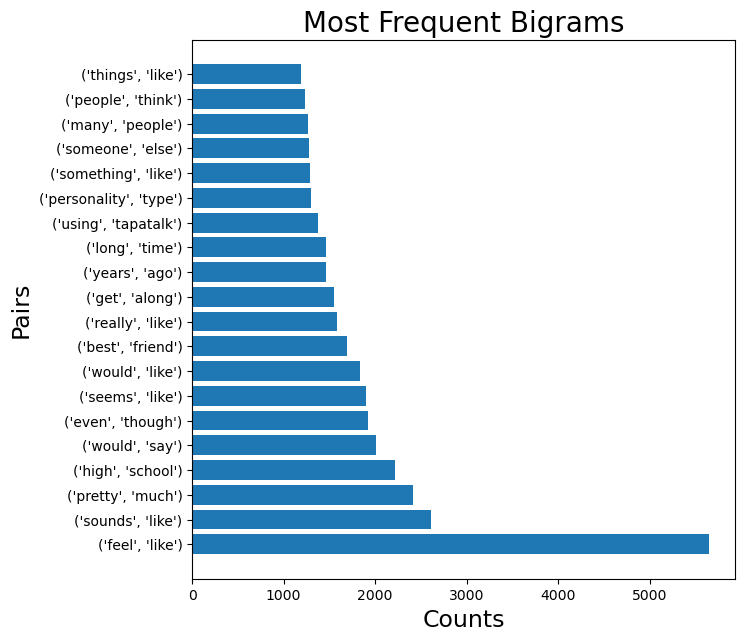

In [45]:
plot_n_grams(bigrams_most_common, title="Most Frequent Bigrams")

In [46]:
trigrams_most_common = most_common_ngram(data, "trigrams")
trigrams_most_common

[(('sent', 'iphone', 'using'), 702),
 (('iphone', 'using', 'tapatalk'), 686),
 (('sent', 'using', 'tapatalk'), 331),
 (('one', 'best', 'friends'), 280),
 (('get', 'along', 'well'), 253),
 (('sometimes', 'feel', 'like'), 210),
 (('long', 'time', 'ago'), 183),
 (('low', 'self', 'esteem'), 173),
 (('anything', 'may', 'affect'), 173),
 (('may', 'affect', 'way'), 171),
 (('affect', 'way', 'answer'), 168),
 (('yes', 'yes', 'yes'), 168),
 (('spend', 'lot', 'time'), 165),
 (('wikipedia', 'free', 'encyclopedia'), 162),
 (('way', 'answer', 'questions'), 158),
 (('answer', 'questions', 'example'), 150),
 (('questions', 'example', 'stressful'), 145),
 (('example', 'stressful', 'time'), 144),
 (('stressful', 'time', 'mental'), 140),
 (('makes', 'feel', 'like'), 137)]

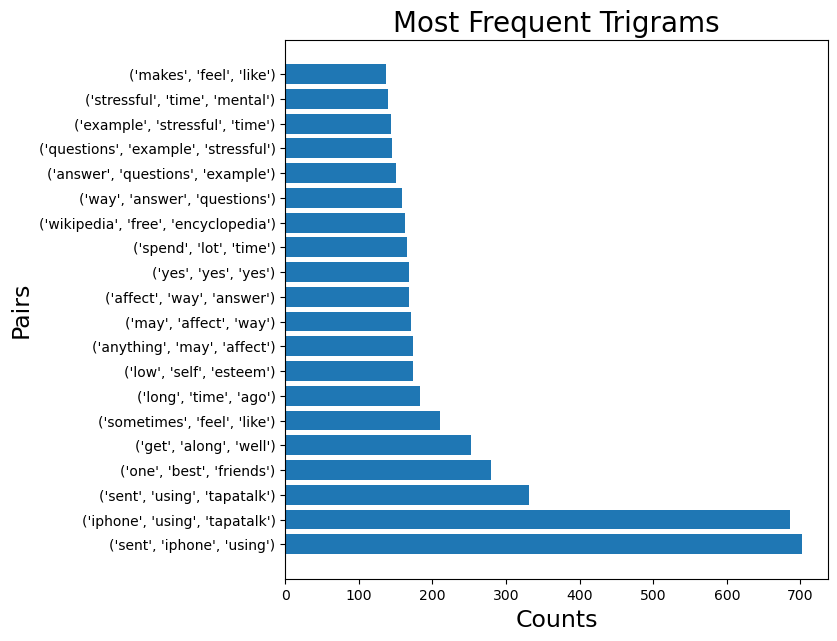

In [47]:
plot_n_grams(trigrams_most_common, title="Most Frequent Trigrams")

In [48]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ranja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ranja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
def remove_stopwords(data, stopword_list, column="cleaned_post"):
    data[column] = data[column].apply(word_tokenize)
    data[column] = data[column].apply(lambda x: [word for word in x if not word in stopword_list])
    return data

def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

In [50]:
def lemmatize(data, stopword_list, column="cleaned_post"):
    data[column] = data[column].apply(apply_lemmatization)
    data[column] = data[column].apply(" ".join)
    return data

In [51]:
for i in range(data.shape[0]):
  post_temp=data._get_value(i, 'posts')
  post_temp=" ".join([w for w in post_temp.split(' ') if w not in remove_words])    #to remove stopwords
  data._set_value(i, 'posts', post_temp)
     

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [52]:
import nltk
nltk.download('omw-1.4')
for i in range(data.shape[0]):
  post_temp=data._get_value(i, 'posts')
  post_temp=" ".join([lemmatizer.lemmatize(w) for w in post_temp.split(' ')])   #to implement lemmetization i.e. to group together different forms of a word
  data._set_value(i, 'posts', post_temp)
     

print(data)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ranja\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


      type                                              posts E-I N-S F-T J-P  \
0     INFJ   enfp intj moment sportscenter top ten play pr...   I   N   F   J   
1     ENTP   finding lack post alarming sex boring positio...   E   N   T   P   
2     INTP   good one course say know blessing curse absol...   I   N   T   P   
3     INTJ   dear intp enjoyed conversation day esoteric g...   I   N   T   J   
4     ENTJ   fired another silly misconception approaching...   E   N   T   J   
...    ...                                                ...  ..  ..  ..  ..   
8670  ISFP   ixfp always think cat fi doms reason especial...   I   S   F   P   
8671  ENFP   thread already exists someplace else post hec...   E   N   F   P   
8672  INTP   many question thing would take purple pill pi...   I   N   T   P   
8673  INFP   conflicted right come wanting child honestly ...   I   N   F   P   
8674  INFP   long since personalitycafe although seem chan...   I   N   F   P   

                           

In [53]:
data.head()

type                                              posts E-I N-S F-T J-P  \
0  INFJ   enfp intj moment sportscenter top ten play pr...   I   N   F   J   
1  ENTP   finding lack post alarming sex boring positio...   E   N   T   P   
2  INTP   good one course say know blessing curse absol...   I   N   T   P   
3  INTJ   dear intp enjoyed conversation day esoteric g...   I   N   T   J   
4  ENTJ   fired another silly misconception approaching...   E   N   T   J   

                                        cleaned_post  words_count  char_count  \
0  enfp intj moments sportscenter top ten plays p...          301        2051   
1  finding lack posts alarming sex boring positio...          542        3591   
2  good one course say know blessing curse absolu...          417        2884   
3  dear intp enjoyed conversation day esoteric ga...          506        3475   
4  fired another silly misconception approaching ...          464        3259   

                                             bigrams  \
0  [(enfp, intj), (intj, moments), (moments, spor...   
1  [(finding, lack), (lack, posts), (posts, alarm...   
2  [(good, one), (one, course), (course, say), (s...   
3  [(dear, intp), (intp, enjoyed), (enjoyed, conv...   
4  [(fired, another), (another, silly), (silly, m...   

                                            trigrams  
0  [(enfp, intj, moments), (intj, moments, sports...  
1  [(finding, lack, posts), (lack, posts, alarmin...  
2  [(good, one, course), (one, course, say), (cou...  
3  [(dear, intp, enjoyed), (intp, enjoyed, conver...  
4  [(fired, another, silly), (another, silly, mis...

In [54]:
training_data = data[["cleaned_post", "E-I", "N-S", "F-T", "J-P"]].copy()
training_data.head(5)

cleaned_post E-I N-S F-T J-P
0  enfp intj moments sportscenter top ten plays p...   I   N   F   J
1  finding lack posts alarming sex boring positio...   E   N   T   P
2  good one course say know blessing curse absolu...   I   N   T   P
3  dear intp enjoyed conversation day esoteric ga...   I   N   T   J
4  fired another silly misconception approaching ...   E   N   T   J

In [55]:
def make_dummies(data, columns=["E-I", "N-S", "F-T", "J-P"]):
    for column in columns:
        temp_dummy = pd.get_dummies(data[column], prefix="type")
        data = data.join(temp_dummy)
    return data

In [56]:
training_data = make_dummies(training_data)
training_data.head()

cleaned_post E-I N-S F-T J-P  type_E  \
0  enfp intj moments sportscenter top ten plays p...   I   N   F   J       0   
1  finding lack posts alarming sex boring positio...   E   N   T   P       1   
2  good one course say know blessing curse absolu...   I   N   T   P       0   
3  dear intp enjoyed conversation day esoteric ga...   I   N   T   J       0   
4  fired another silly misconception approaching ...   E   N   T   J       1   

   type_I  type_N  type_S  type_F  type_T  type_J  type_P  
0       1       1       0       1       0       1       0  
1       0       1       0       0       1       0       1  
2       1       1       0       0       1       0       1  
3       1       1       0       0       1       1       0  
4       0       1       0       0       1       1       0

In [57]:
X = training_data[["cleaned_post"]]
y = training_data.drop(columns=["cleaned_post"])

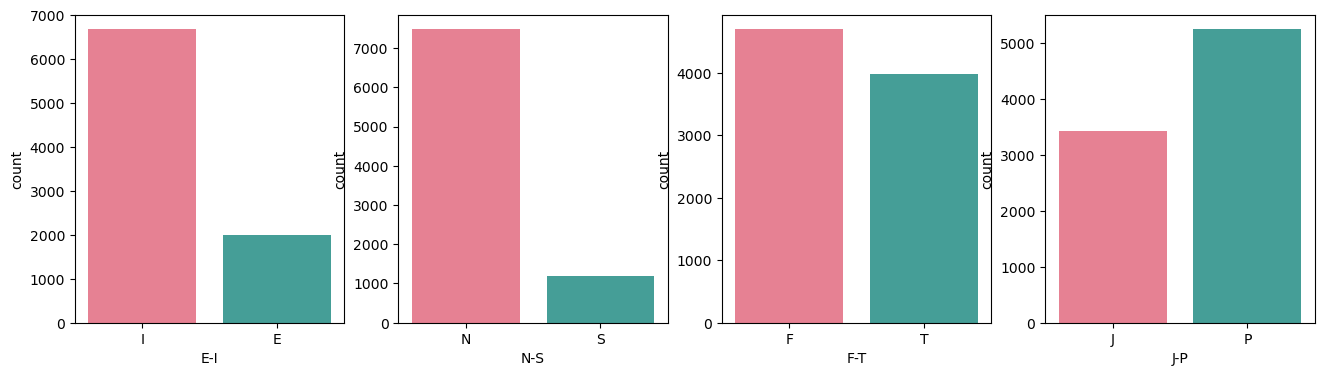

In [58]:
def show_distribution(data, x=["E-I", "N-S", "F-T","J-P"], fig_size=(16,4), xticks_size=10, palette="husl"):
    fig, ax = plt.subplots(len(x), figsize=fig_size)
    j = 0
    for _x in x:
        plt.subplot(1,4, j+1)
        sns.countplot(x=_x, data=data, palette=palette)
        plt.xticks(size=xticks_size)
        j+=1    
        
show_distribution(data)

In [59]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()

y_ei = y["type_E"]
y_ns = y["type_N"]
y_ft = y["type_F"]
y_jp = y["type_J"]

X_over_ei, y_over_ei = oversample.fit_resample(X, y_ei)
X_over_ns, y_over_ns = oversample.fit_resample(X, y_ns)
X_over_ft, y_over_ft = oversample.fit_resample(X, y_ft)
X_over_jp, y_over_jp = oversample.fit_resample(X, y_jp)

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\ranja\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)

In [60]:
show_class_distribution(data=X_over_ei, x=y_over_ei, figsize=(7,3), title="E-I")

NameError: name 'X_over_ei' is not defined

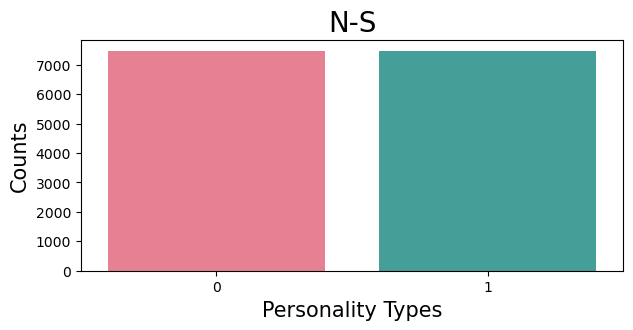

In [61]:
show_class_distribution(data=X_over_ns, x=y_over_ns, figsize=(7,3), title="N-S")

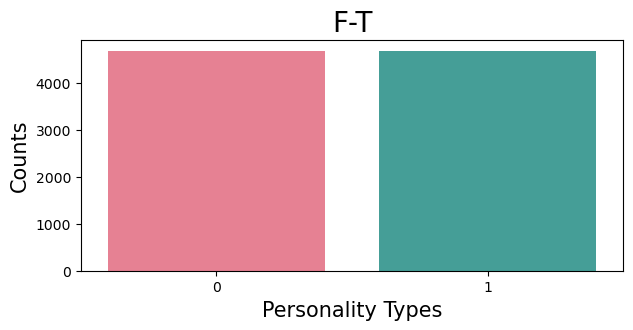

In [62]:
show_class_distribution(data=X_over_ft, x=y_over_ft, figsize=(7,3), title="F-T")

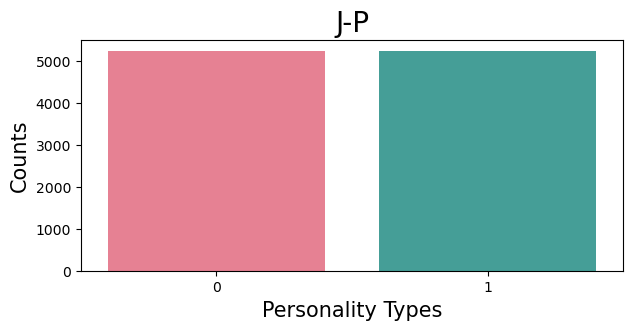

In [63]:
show_class_distribution(data=X_over_jp, x=y_over_jp, figsize=(7,3), title="J-P")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
X_train_ei, X_test_ei, y_train_ei, y_test_ei = train_test_split(X_over_ei, y_over_ei, test_size=0.3, random_state=42)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_over_ns, y_over_ns, test_size=0.3, random_state=42)
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_over_ft, y_over_ft, test_size=0.3, random_state=42)
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X_over_jp, y_over_jp, test_size=0.3, random_state=42)

X_train_ei = X_train_ei['cleaned_post']
X_train_ns = X_train_ns['cleaned_post']
X_train_ft = X_train_ft['cleaned_post']
X_train_jp = X_train_jp['cleaned_post']

X_test_ei = X_test_ei['cleaned_post']
X_test_ns = X_test_ns['cleaned_post']
X_test_ft = X_test_ft['cleaned_post']
X_test_jp = X_test_jp['cleaned_post']

y_train_ei.name, y_test_ei.name = "E-I", "E-I"
y_train_ns.name, y_test_ns.name = "N-S", "N-S"
y_train_ft.name, y_test_ft.name = "F-T", "F-T"
y_train_jp.name, y_test_jp.name = "J-P", "J-P"

y_all_train = [y_train_ei, y_train_ns, y_train_ft,  y_train_jp]
y_all_test  = [y_test_ei, y_test_ns, y_test_ft, y_test_jp] 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit(X_train_ei)

In [47]:
X_train_ei = vectorizer.transform(X_train_ei)
X_test_ei  = vectorizer.transform(X_test_ei)

X_train_ns = vectorizer.transform(X_train_ns)
X_test_ns  = vectorizer.transform(X_test_ns)

X_train_ft = vectorizer.transform(X_train_ft)
X_test_ft  = vectorizer.transform(X_test_ft)

X_train_jp = vectorizer.transform(X_train_jp)
X_test_jp  = vectorizer.transform(X_test_jp)

x_all_train = [X_train_ei, X_train_ns, X_train_ft, X_train_jp]
x_all_test  = [X_test_ei, X_test_ns, X_test_ft, X_test_jp]

In [48]:
tf_idf = pd.DataFrame(X_test_ei.toarray(), columns=vectorizer.get_feature_names_out())
tf_idf.head(10)

aaaand  aang  aback  abandon  abandoned  abhor  abilities   ability  abit  \
0     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
1     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
2     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
3     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
4     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
5     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
6     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
7     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.065763   0.0   
8     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.000000   0.0   
9     0.0   0.0    0.0      0.0        0.0    0.0        0.0  0.032276   0.0   

       able  ...  zero    zodiac  zoe  zombie  zombies      zone  zoned  \
0  0.000000  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   
1  0.000000  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   
2  0.022878  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   
3  0.000000  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   
4  0.000000  ...   0.0  0.114979  0.0     0.0      0.0  0.045827    0.0   
5  0.030561  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   
6  0.000000  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   
7  0.000000  ...   0.0  0.000000  0.0     0.0      0.0  0.092195    0.0   
8  0.000000  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   
9  0.000000  ...   0.0  0.000000  0.0     0.0      0.0  0.000000    0.0   

   zoning  zoo  zoom  
0     0.0  0.0   0.0  
1     0.0  0.0   0.0  
2     0.0  0.0   0.0  
3     0.0  0.0   0.0  
4     0.0  0.0   0.0  
5     0.0  0.0   0.0  
6     0.0  0.0   0.0  
7     0.0  0.0   0.0  
8     0.0  0.0   0.0  
9     0.0  0.0   0.0  

[10 rows x 10000 columns]

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pickle
from sklearn import metrics

def create_models():
    nb_clf  = MultinomialNB(alpha=0.01)
    svm_clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    dt_clf  = DecisionTreeClassifier(max_depth=7)
    rf_clf  = RandomForestClassifier(n_estimators=750)
    xgb_clf = xgboost.XGBClassifier(use_label_encoder=False)
    return {"NaiveBayes":nb_clf, "SVM":svm_clf, "DecisionTree":dt_clf, "RandomForest":rf_clf, "Xgboost":xgb_clf}

#Model Performance Evaluation with accuracy & f1-score & roc-auc score

_metrics = ["Accuracy", "Accuracy", "Accuracy" ,"Accuracy", "Precision", "Precision", "Precision","Precision", "Recall","Recall","Recall","Recall", "F1-Score", "F1-Score", "F1-Score", "F1-Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score"]
_types   = ["E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P"]
_columns = ["NaiveBayes", "SVM", "DecisionTree", "RandomForest", "Xgboost"]

In [50]:
evaluation_df = pd.DataFrame(columns=_columns, index=[_metrics, _types])
evaluation_df

NaiveBayes  SVM DecisionTree RandomForest Xgboost
Accuracy      E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
Precision     E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
Recall        E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
F1-Score      E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN
Roc-Auc Score E-I        NaN  NaN          NaN          NaN     NaN
              N-S        NaN  NaN          NaN          NaN     NaN
              F-T        NaN  NaN          NaN          NaN     NaN
              J-P        NaN  NaN          NaN          NaN     NaN

In [51]:
models = create_models()
models

{'NaiveBayes': MultinomialNB(alpha=0.01),
 'SVM': SVC(gamma='auto', kernel='linear'),
 'DecisionTree': DecisionTreeClassifier(max_depth=7),
 'RandomForest': RandomForestClassifier(n_estimators=750),
 'Xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...)}

In [ ]:
for model_item in models.items():
    for X_train, X_test, y_train, y_test in zip(x_all_train, x_all_test, y_all_train, y_all_test):
        # Model creation and prediction
        model = model_item[1]
        print(f"{model} is training for {y_train.name}...")
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        # Performance evaluation metrics
        evaluation_df.loc["Accuracy",y_train.name][model_item[0]]      = round(metrics.accuracy_score(y_test, pred), 3)
        evaluation_df.loc["Precision",y_train.name][model_item[0]]     = round(metrics.precision_score(y_test, pred), 3)
        evaluation_df.loc["Recall",y_train.name][model_item[0]]        = round(metrics.recall_score(y_test, pred), 3)        
        evaluation_df.loc["F1-Score",y_train.name][model_item[0]]      = round(metrics.f1_score(y_test, pred), 3)
        evaluation_df.loc["Roc-Auc Score",y_train.name][model_item[0]] = round(metrics.roc_auc_score(y_test, pred), 3)        
        # Save model
        filename = 'C:/Users/ranja/Downloads/NaiveBayes_E-I.sav'
        pickle.dump(model,open(filename, 'wb'))

In [ ]:
evaluation_df